In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
def C_L0_norm(x):
    '''L0 norm function for each element of a vector'''
    if x != 0:
        return 0.0
    else:
        return 1.0

def C_L1_norm(x):
    '''L1 norm function for each element of a vector'''
    return abs(x)

def C_L0_norm_deriv(x):
    '''Derivative of C_L0_norm'''
    if x != 0:
        return 0.0
    else:
        return np.inf
    
def C_L1_norm(x):
    '''Derivative of C_L1_norm'''
    if x < 0:
        return -1.0
    elif x > 0:
        return 1.0
    else:
        return np.inf

In [73]:
def T(um, lamb, norm_type):
    '''Threshold function as described'''
    if norm_type == 'L0':
        return max(um, 0.0)
    elif norm_type == 'L1':
        return max(um - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')

def find_u_dot(tau, u, A, y, lamb):
    s = T_vec(u, lamb, 'L0')
    b = np.dot(A.T, y)
    A_shift = np.dot(A.T, A) - np.identity(A.shape[1])
    return (b - u - np.dot(A_shift, s)) / tau
    
T_vec = np.vectorize(T)

def find_s(tau, A, y, lamb, niter=100):
    # Initialize
    u = np.zeros(A.shape[1], dtype='float')
    for i in range(niter):
        udot = find_u_dot(tau, u, A, y, lamb)
        #print(udot)
        u += udot * 0.001
        #print('u=', u)
    return T_vec(u, lamb, 'L1')

In [85]:
b = np.array([1, 1, 3], dtype='float')
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
s = np.array([3,3,4], dtype='float')
u = np.array([5, -4, 3], dtype='float')
y = np.array([30, 49, 79], dtype='float')
tau = 1.0
lamb = 0.001

In [87]:
v = find_s(tau, A, y, lamb, niter=100)
np.dot(A,v)

array([ 30.2750583 ,  48.67112009,  79.00564512])

In [23]:
def learn_step(y, A, s, eta):
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T))
    return A_new

In [24]:

eta = 0.1
learn_step(y, A, s, eta)

array([[-25.1, -23.1, -22.1],
       [-30.1, -21.1, -32.1],
       [-26.1, -18.1, -15.1]])

In [41]:
# Read in sound file
fs, sound = scipy.io.wavfile.read('American-English/Consonants/azure.wav')

In [62]:
soundfiles = glob.glob('./American-English/*/*.wav')
sound_combined = np.zeros(0)
for file in soundfiles:
    fs, sound = scipy.io.wavfile.read(file)
    sound_combined = np.concatenate((sound_combined, sound))

In [63]:
sound_combined.shape

(1259716,)

In [64]:
f,t,spectrogram = scipy.signal.spectrogram(sound_combined, fs)

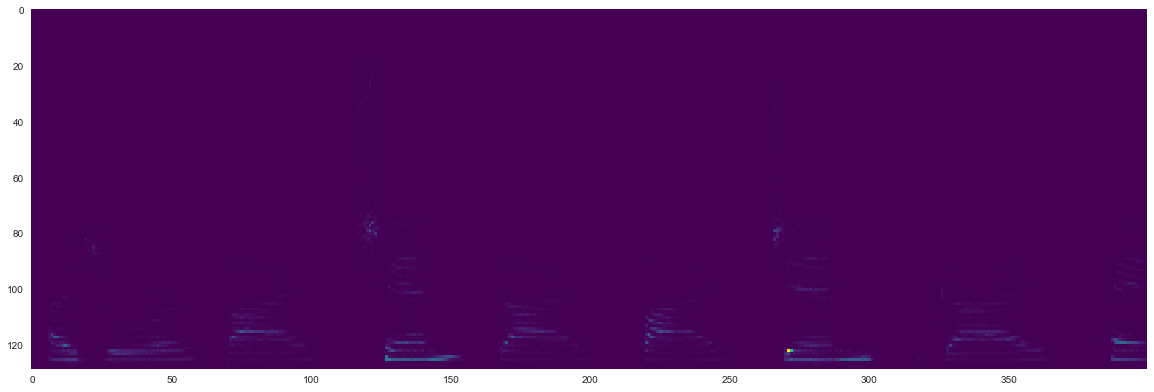

In [82]:
plt.figure(figsize=(20,20))
plt.imshow(np.flipud(spectrogram)[:,:400], cmap='viridis');
plt.grid(False)

In [110]:
# Segment into overlapping segments
segment_len = 20 #samples
segment_step = 5 #samples
segments_lst = []
for t_start in np.arange(0, len(t) - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])

In [112]:
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()


In [156]:
# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X.T)
X_red = pca.transform(X.T)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

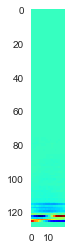

In [169]:
# Visualize principal components
comp = pca.components_
a = comp[3,:].reshape((129, 20))
plt.grid(False)
plt.imshow(np.flipud(a), cmap='jet')

In [ ]:
## Do the learning algorithm
